In [175]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore
import math
import matplotlib.pyplot as plt
import os

import py_stringmatching as sm

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 100)

## **DQ Check**

1. Map teams by hand
2. Map players using `jaro winkler`
3. Aggregate Wyscout
4. Aggregate Opta
5. Link and calculate ratios

### Things to aggregate over:
* Minutes played
* Passes attempted
* Shots attempted
* Dribbles attempted


### **Loading Wyscout**

In [270]:
path_wyscout = f'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Wyscout xT/Wyscout_Domestic_Comps_xT_Opta_Surface.csv'
path_wyscout_formations = f'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Wyscout Reference/df_wyscout_formations.csv'
path_wyscout_players = f'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Wyscout Reference/player_positions.csv'
path_wyscout_teams = f'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Wyscout Reference/df_teams.csv'

df_wyscout = pd.read_csv(path_wyscout)
df_wyscout_formations = pd.read_csv(path_wyscout_formations)
df_wyscout_players = pd.read_csv(path_wyscout_players)
df_wyscout_teams = pd.read_csv(path_wyscout_teams)

# filtering straight away on England
df_wyscout = df_wyscout.loc[df_wyscout['source'] == 'England'].copy()

# getting the longer player names
df_wyscout = df_wyscout.merge(df_wyscout_players, how='inner', left_on='playerId', right_on='player_id').rename(columns={'player_name':'playerName'})

# trimming columns
df_wyscout = df_wyscout[['matchId','teamId','playerId','shortName','playerName','eventSubType']]


In [271]:
# will be using this table to get wyscout minutes - need to filter on the EPL matches
df_wyscout_formations = df_wyscout_formations.loc[df_wyscout_formations['matchId'].isin(df_wyscout.matchId.values)]

In [272]:
# re-engineering higher level taxonomy movement / shoot types
df_wyscout['eventType'] = df_wyscout.eventSubType.apply(lambda x: 'Pass' if x in ['Successful Pass','Failed Pass']\
                                                                        else 'Shot' if x in ['Goal','Failed Shot']\
                                                                        else 'Dribble' if x in ['Successful Take-On','Failed Take-On','Neutral Take-On']\
                                                                        else 'Not Relevant')

# filtering out non-movement / shot types (i.e. not relevant for xT and this project)
df_wyscout = df_wyscout.loc[df_wyscout['eventType'] != 'Not Relevant'].reset_index(drop=True).copy()

In [273]:
# okay before we do the aggregation we need to get the canonical team for each player for the season
# think Alexis Sanchez moved mid-season
# for this mapping work, we don't need to know both teams, it's just going to help us having the team as a first stage of the mapping
# so lets calculate the most frequent team per player, and make a canonical team mapping table
df_wyscout_player_team_mapping = df_wyscout.groupby(['playerId','shortName','playerName','teamId'])\
                            .agg({'eventType':'count'})\
                            .rename(columns={'eventType':'numEventsPerTeam'})\
                            .reset_index()

df_wyscout_player_team_mapping['RN'] = df_wyscout_player_team_mapping.sort_values(['playerId','numEventsPerTeam'], ascending=[True,False])\
                                                                        .groupby('playerId')\
                                                                        .cumcount() + 1

# picking the team with the most events as the canonical team for the player for that year
df_wyscout_player_team_mapping = df_wyscout_player_team_mapping.loc[df_wyscout_player_team_mapping['RN'] == 1].drop(columns=['RN','numEventsPerTeam'])

df_wyscout_player_team_mapping.head()

,playerId,shortName,playerName,teamId
0,36,T. Alderweireld,Toby Alderweireld,1624
1,38,D. Blind,Daley Blind,1611
2,48,J. Vertonghen,Jan Vertonghen,1624
3,54,C. Eriksen,Christian Dannemann Eriksen,1624
4,56,D. Klaassen,Davy Klaassen,1623


In [274]:
# let's now drop the teamId from df_wyscout and replace with the new canonical teamId
df_wyscout = df_wyscout.drop(columns='teamId')
df_wyscout = df_wyscout.merge(df_wyscout_player_team_mapping)

In [275]:
# now we can start to calculate aggregate metrics from the wyscout data
df_wyscout_agg = df_wyscout.groupby(['playerId','shortName','playerName','teamId','eventType'])\
                .agg({'matchId':'count'})\
                .rename(columns={'matchId':'numEvents'})\
                .reset_index()

df_wyscout_agg = pd.pivot(df_wyscout_agg, index=['playerId','shortName','playerName','teamId'], columns=['eventType'], values=['numEvents']).reset_index()
df_wyscout_agg.columns = ['playerIdWy','shortNameWy','playerNameWy','teamIdWy','DribbleWy','PassWy','ShotWy']

# adding in minutes played
df_wyscout_minutes_played = df_wyscout_formations.groupby('playerId').agg({'minutesPlayed':np.sum}).reset_index().rename(columns={'minutesPlayed':'minsPlayedWy','playerId':'playerIdWy'})
df_wyscout_agg = df_wyscout_agg.merge(df_wyscout_minutes_played)

print (f'{len(df_wyscout_agg)} Players in Wyscout')

df_wyscout_agg.head()

513 Players in Wyscout


,playerIdWy,shortNameWy,playerNameWy,teamIdWy,DribbleWy,PassWy,ShotWy,minsPlayedWy
0,36,T. Alderweireld,Toby Alderweireld,1624,5.0,898.0,10.0,1176.0
1,38,D. Blind,Daley Blind,1611,2.0,224.0,3.0,360.0
2,48,J. Vertonghen,Jan Vertonghen,1624,19.0,2370.0,23.0,3204.0
3,54,C. Eriksen,Christian Dannemann Eriksen,1624,37.0,2196.0,80.0,3226.0
4,56,D. Klaassen,Davy Klaassen,1623,1.0,97.0,1.0,250.0


### **Loading Opta**

In [276]:
path_opta = f'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT & xG/Bayesian_Opta_xT_xG.csv'
path_opta_players = f'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/PLAYER KPIs/df_players.csv'
df_opta = pd.read_csv(path_opta).drop(columns=['Unnamed: 0'])
df_opta_players = pd.read_csv(path_opta_players)

# only interested in overlapping data in EPL 2017/18 season
df_opta = df_opta.loc[(df_opta['competition'] == 'English Premier League') & (df_opta['season'] == '2017/18')]

df_opta_teams = df_opta[['homeTeamId','homeTeamName']].drop_duplicates().rename(columns={'homeTeamId':'teamId','homeTeamName':'teamName'})

# filtering columns
df_opta = df_opta[['matchId','playerId','playerName','playerTeamId','minsPlayed','eventType','eventSubType']]

In [277]:
# okay before we do the aggregation we need to get the canonical team for each player for the season
# think Alexis Sanchez moved mid-season
# for this mapping work, we don't need to know both teams, it's just going to help us having the team as a first stage of the mapping
# so lets calculate the most frequent team per player, and make a canonical team mapping table
df_opta_player_team_mapping = df_opta.groupby(['playerId','playerName','playerTeamId'])\
                            .agg({'eventType':'count'})\
                            .rename(columns={'eventType':'numEventsPerTeam'})\
                            .reset_index()

df_opta_player_team_mapping['RN'] = df_opta_player_team_mapping.sort_values(['playerId','numEventsPerTeam'], ascending=[True,False])\
                                                                        .groupby('playerId')\
                                                                        .cumcount() + 1

# picking the team with the most events as the canonical team for the player for that year
df_opta_player_team_mapping = df_opta_player_team_mapping.loc[df_opta_player_team_mapping['RN'] == 1].drop(columns=['RN','numEventsPerTeam'])

df_opta_player_team_mapping.head()

,playerId,playerName,playerTeamId
0,1632,Gareth Barry,35
1,2404,Michael Carrick,1
2,2513,Jamie Murphy,36
3,3773,Peter Crouch,110
4,5589,Dean Whitehead,38


In [278]:
# re-engineering higher level taxonomy movement / shoot types
df_opta['eventType'] = df_opta.eventSubType.apply(lambda x: 'Pass' if x in ['Pass','Failed Pass','Assist','2nd Assist','Chance Created','Cross','Offside Pass']\
                                                                        else 'Shot' if x in ['Goal','Hit Woodwork','Miss','Missed Penalty','Penalty Saved','Shot Blocked','Shot Saved']\
                                                                        else 'Dribble' if x in ['Dribble','Failed Dribble']\
                                                                        else 'Not Relevant')

# filtering out non-movement / shot types (i.e. not relevant for xT and this project)
df_opta = df_opta.loc[df_opta['eventType'] != 'Not Relevant'].reset_index(drop=True).copy()

In [279]:
# let's now drop the teamId from df_wyscout and replace with the new canonical teamId
df_opta = df_opta.drop(columns='playerTeamId')
df_opta = df_opta.merge(df_opta_player_team_mapping).rename(columns={'playerTeamId':'teamId'})

In [280]:
# now we can start to calculate aggregate metrics from the wyscout data
df_opta_agg = df_opta.groupby(['playerId','playerName','teamId','eventType'])\
                .agg({'matchId':'count'})\
                .rename(columns={'matchId':'numEvents'})\
                .reset_index()

df_opta_agg = pd.pivot(df_opta_agg, index=['playerId','playerName','teamId'], columns=['eventType'], values=['numEvents']).reset_index()
df_opta_agg.columns = ['playerIdOpta','playerNameOpta','teamIdOpta','DribbleOpta','PassOpta','ShotOpta']

# integrating minutes played
df_opta_mins_played = df_opta[['playerId','matchId','minsPlayed']].drop_duplicates().drop(columns='matchId').groupby('playerId').agg({'minsPlayed':np.sum}).reset_index().rename(columns={'playerId':'playerIdOpta','minsPlayed':'minsPlayedOpta'})
df_opta_agg = df_opta_agg.merge(df_opta_mins_played)

print (f'{len(df_opta_agg)} Players in Opta')

df_opta_agg.head()

484 Players in Opta


,playerIdOpta,playerNameOpta,teamIdOpta,DribbleOpta,PassOpta,ShotOpta,minsPlayedOpta
0,1632,Gareth Barry,35,11.0,963.0,16.0,2016
1,2404,Michael Carrick,1,2.0,99.0,2.0,113
2,2513,Jamie Murphy,36,2.0,45.0,1.0,181
3,3773,Peter Crouch,110,10.0,643.0,23.0,1682
4,5589,Dean Whitehead,38,NaN,51.0,NaN,82


### Quick comparison between total counts of movement events between the two datasets

In [281]:
df_opta.eventType.value_counts()

Pass       371896
Dribble     12926
Shot         9113
Name: eventType, dtype: int64

In [282]:
df_wyscout.eventType.value_counts()

Pass       328651
Dribble      8907
Shot         8450
Name: eventType, dtype: int64

---

## **Mapping**

### **Mapping Teams By Hand**

In [283]:
dic_team_mapping = {
    'Manchester United':[1, 1611],
    'Arsenal':[3,1609],
    'Newcastle United':[4,1613],
    'Spurs':[6,1624],
    'Chelsea':[8,1610],
    'Everton':[11,1623],
    'Leicester City':[13,1631],
    'Liverpool':[14,1612],
    'Southampton':[20,1619],
    'West Ham United':[21,1633],
    'Crystal Palace':[31,1628],
    'WBA':[35,1627],
    'Brighton':[36,1651],
    'Huddersfield':[38,1673],
    'Manchester City':[43,1625],
    'Watford':[57,1644],
    'Swansea':[80,10531],
    'Burnley':[90,1646],
    'Bournemouth':[91,1659],
    'Stoke City':[110,1639]
}

df_team_mapping = pd.DataFrame.from_dict(dic_team_mapping, orient='index', columns=['teamIdOpta','teamIdWy'])

df_team_mapping

,teamIdOpta,teamIdWy
Manchester United,1,1611
Arsenal,3,1609
Newcastle United,4,1613
Spurs,6,1624
Chelsea,8,1610
Everton,11,1623
Leicester City,13,1631
Liverpool,14,1612
Southampton,20,1619
West Ham United,21,1633


### **Mapping Players by String Matching**

In [291]:
%%time

# will hold player mappings in this dictionary
dic_player_match = {}

# initialising Jaro Winkler name match
jw = sm.JaroWinkler()

# this is the list of things we want to map
lst_opta_players = np.unique(df_opta_agg.playerIdOpta.values)

# candidates that we'll reduce as we make mappings
df_candidates = df_wyscout_agg.copy()

# doing this once with high jaro barrier
for opta_player in lst_opta_players:
    
    playerNameOpta, teamIdOpta = df_opta_agg.loc[df_opta_agg['playerIdOpta'] == opta_player, ['playerNameOpta','teamIdOpta']].values[0]
    
    # immediately can map to wyscout players for that team
    teamIdWy = df_team_mapping.loc[df_team_mapping['teamIdOpta'] == teamIdOpta, 'teamIdWy'].values[0]
    
    # getting player candidates
    df_player_candidates = df_candidates.loc[df_candidates['teamIdWy'] == teamIdWy, ['playerIdWy','playerNameWy']]
    
    # getting jaro scores
    df_player_candidates['JaroScore'] = df_player_candidates.playerNameWy.apply(lambda x: jw.get_raw_score(playerNameOpta.lower(), x.lower()))
    
    # producing mapping
    try:
        mapping = df_player_candidates.loc[df_player_candidates['JaroScore'] >= 0.9].sort_values('JaroScore', ascending=False).playerIdWy.values[0]
        js = df_player_candidates.loc[df_player_candidates['JaroScore'] >= 0.9].sort_values('JaroScore', ascending=False).JaroScore.values[0]
        dic_player_match[opta_player] = [mapping, js]
    except:
        mapping = np.NaN
    
    #dic_player_match[opta_player] = mapping
    
    # remove mapped candidate from candidate pool
    # this ensures we don't have any duplicates
    df_candiates = df_candidates.loc[df_candidates['playerIdWy'] != mapping]
    

lst_opta_players = set(lst_opta_players) - set(dic_player_match.keys())
    
## second time round with lower barrier, after solving for 90% of cases
# doing this once with high jaro barrier
for opta_player in lst_opta_players:
    
    playerNameOpta, teamIdOpta = df_opta_agg.loc[df_opta_agg['playerIdOpta'] == opta_player, ['playerNameOpta','teamIdOpta']].values[0]
    
    # immediately can map to wyscout players for that team
    teamIdWy = df_team_mapping.loc[df_team_mapping['teamIdOpta'] == teamIdOpta, 'teamIdWy'].values[0]
    
    # getting player candidates
    df_player_candidates = df_candidates.loc[df_candidates['teamIdWy'] == teamIdWy, ['playerIdWy','playerNameWy']]
    
    # getting jaro scores
    df_player_candidates['JaroScore'] = df_player_candidates.playerNameWy.apply(lambda x: jw.get_raw_score(playerNameOpta.lower(), x.lower()))
    
    # producing mapping
    try:
        mapping = df_player_candidates.loc[df_player_candidates['JaroScore'] >= 0.78].sort_values('JaroScore', ascending=False).playerIdWy.values[0]
        js = df_player_candidates.loc[df_player_candidates['JaroScore'] >= 0.78].sort_values('JaroScore', ascending=False).JaroScore.values[0]
        dic_player_match[opta_player] = [mapping, js]
    except:
        mapping = np.NaN
    
    #dic_player_match[opta_player] = mapping
    
    # remove mapped candidate from candidate pool
    # this ensures we don't have any duplicates
    df_candiates = df_candidates.loc[df_candidates['playerIdWy'] != mapping]

df_player_match = pd.DataFrame.from_dict(dic_player_match, orient='index', columns=['playerIdWy','jaroScore'])
df_player_match['playerIdOpta'] = df_player_match.index

df_player_match = df_player_match.merge(df_opta_agg, how='inner', on='playerIdOpta')
df_player_match = df_player_match.merge(df_wyscout_agg, how='left', on='playerIdWy')[['playerIdOpta','playerNameOpta','playerNameWy','playerIdWy','jaroScore']]

# patching obvious errors
df_player_match = df_player_match.loc[~df_player_match['playerIdWy'].isin([7967,105333,397178])]

numMapped = len(df_player_match)
pcMapped = np.round(100*numMapped / len(df_opta_agg), 1)

print (f'Mapped {pcMapped} of Opta Players')

Mapped 95.7 of Opta Players
CPU times: user 2.57 s, sys: 11.4 ms, total: 2.58 s
Wall time: 2.58 s


In [336]:
numMapped

463

In [337]:
len(df_opta_agg)

484

In [331]:
df_player_match.sort_values('jaroScore').head()

,playerIdOpta,playerNameOpta,playerNameWy,playerIdWy,jaroScore
426,108823,Dele Alli,Bamidele Alli,13484,0.786325
416,121221,Ramiro Funes Mori,José Ramiro Funes Mori,86325,0.786988
422,46483,Adrien Silva,Adrien Sebastian Perruchet Silva,70403,0.809167
440,20664,David Silva,David Josué Jiménez Silva,8317,0.809455
452,76542,Ki Sung-Yueng,Sung-Yeung Ki,61962,0.812820


In [334]:
df_player_match.sort_values('jaroScore', ascending=False).head(20)[['playerNameOpta','playerNameWy','jaroScore']].to_latex(index=False).replace('\\\\\n','\\')

'\\begin{tabular}{llr}\n\\toprule\n          playerNameOpta &             playerNameWy &  jaroScore \\\\midrule\n            Gareth Barry &             Gareth Barry &        1.0 \\              Lewis Dunk &               Lewis Dunk &        1.0 \\   Christopher Schindler &    Christopher Schindler &        1.0 \\      Bruno Martins Indi &       Bruno Martins Indi &        1.0 \\              Danny Ings &               Danny Ings &        1.0 \\          Beni Baningime &           Beni Baningime &        1.0 \\            Granit Xhaka &             Granit Xhaka &        1.0 \\           Collin Quaner &            Collin Quaner &        1.0 \\       Anthony Knockaert &        Anthony Knockaert &        1.0 \\           Jeff Hendrick &            Jeff Hendrick &        1.0 \\          Nathan Redmond &           Nathan Redmond &        1.0 \\         Jeffrey Schlupp &          Jeffrey Schlupp &        1.0 \\           Wilfried Zaha &            Wilfried Zaha &        1.0 \\               S

## DQ Analysis

In [293]:
df = df_opta_agg.merge(df_player_match).merge(df_wyscout_agg)
df.head()

,playerIdOpta,playerNameOpta,teamIdOpta,DribbleOpta,PassOpta,ShotOpta,minsPlayedOpta,playerNameWy,playerIdWy,jaroScore,shortNameWy,teamIdWy,DribbleWy,PassWy,ShotWy,minsPlayedWy
0,1632,Gareth Barry,35,11.0,963.0,16.0,2016,Gareth Barry,8314,1.0,G. Barry,1627,8.0,876.0,13.0,1925.0
1,2404,Michael Carrick,1,2.0,99.0,2.0,113,Michael Carrick,7928,1.0,M. Carrick,1611,NaN,96.0,2.0,109.0
2,2513,Jamie Murphy,36,2.0,45.0,1.0,181,Jamie Murphy,62091,1.0,J. Murphy,1651,2.0,41.0,1.0,165.0
3,3773,Peter Crouch,110,10.0,643.0,23.0,1682,Peter Crouch,8747,1.0,P. Crouch,1639,5.0,383.0,21.0,1554.0
4,5589,Dean Whitehead,38,NaN,51.0,NaN,82,Dean Whitehead,8745,1.0,D. Whitehead,1673,NaN,44.0,NaN,67.0


### Calculating DQ Metrics (Ratios of Opta:Wyscout Counts per Player)

In [301]:
df['Dribble'] = df.DribbleOpta / df.DribbleWy
df['Pass'] = df.PassOpta / df.PassWy
df['Shot'] = df.ShotOpta / df.ShotWy
df['Minutes Played'] = df.minsPlayedOpta / df.minsPlayedWy

df['Dribble'] = df.Dribble.apply(lambda x: x if x < 3 else 3 if pd.isna(x) == False else np.NaN)

### Melting Data for R Plotting

In [304]:
df_melt = pd.melt(df, id_vars=['playerIdOpta','playerNameOpta','playerNameWy','playerIdWy'], value_vars=['Dribble','Pass','Shot','Minutes Played'], var_name='Ratio')

# outputting melt to R
df_melt.to_csv('Opta_V_Wyscout_DQ_for_R.csv', index=None)

### Investigating Some of the Outliers

In [308]:
df.sort_values('PassOpta', ascending=False).head()

,playerIdOpta,playerNameOpta,teamIdOpta,DribbleOpta,PassOpta,ShotOpta,minsPlayedOpta,playerNameWy,playerIdWy,jaroScore,shortNameWy,teamIdWy,DribbleWy,PassWy,ShotWy,minsPlayedWy,Dribble,Pass,Shot,Minutes Played
269,84450,Granit Xhaka,3,25.0,3248.0,66.0,3386,Granit Xhaka,49876,1.000000,G. Xhaka,1609,15.0,2974.0,58.0,3266.0,1.666667,1.092132,1.137931,1.036742
186,57410,Nicolás Otamendi,43,7.0,3082.0,32.0,3103,Nicolás Hernán Otamendi,70086,0.901630,N. Otamendi,1625,5.0,2964.0,31.0,2969.0,1.400000,1.039811,1.032258,1.045133
212,61366,Kevin De Bruyne,43,92.0,3008.0,94.0,3200,Kevin De Bruyne,38021,1.000000,K. De Bruyne,1625,54.0,2672.0,74.0,3084.0,1.703704,1.125749,1.270270,1.037613
66,27789,Fernandinho,43,30.0,2999.0,47.0,3019,Fernando Luiz Rosa,105339,0.841414,Fernandinho,1625,23.0,2842.0,48.0,2885.0,1.304348,1.055243,0.979167,1.046447
114,41328,César Azpilicueta,8,10.0,2924.0,13.0,3491,César Azpilicueta Tanco,25553,0.947826,Azpilicueta,1610,6.0,2713.0,12.0,3330.0,1.666667,1.077774,1.083333,1.048348


<AxesSubplot:>

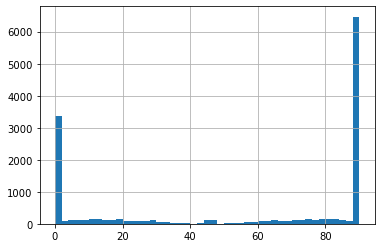

In [321]:
df_wyscout_formations.minutesPlayed.hist(bins=45)

<AxesSubplot:>

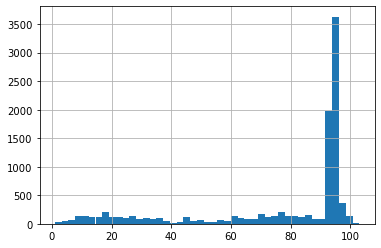

In [325]:
df_opta[['matchId','playerId','minsPlayed']].drop_duplicates().minsPlayed.hist(bins=45)

In [326]:
df_opta[['matchId','playerId','minsPlayed']].drop_duplicates().to_csv('R_Opta_Mins.csv', index=None)

In [328]:
df_wyscout_formations.loc[df_wyscout_formations['minutesPlayed'] != 0.0].to_csv('R_Wyscout_Mins.csv', index=None)

In [324]:
df_opta

,matchId,playerId,playerName,minsPlayed,eventType,eventSubType,teamId
0,918893,59966,Alexandre Lacazette,95,Pass,Pass,3
1,918893,59966,Alexandre Lacazette,95,Shot,Goal,3
2,918893,59966,Alexandre Lacazette,95,Pass,Pass,3
3,918893,59966,Alexandre Lacazette,95,Pass,Failed Pass,3
4,918893,59966,Alexandre Lacazette,95,Pass,Failed Pass,3
...,...,...,...,...,...,...,...
393930,919267,42899,Sergio Romero,93,Pass,Pass,1
393931,919267,42899,Sergio Romero,93,Pass,Failed Pass,1
393932,919267,42899,Sergio Romero,93,Pass,Failed Pass,1
393933,919268,92170,Massadio Haidara,5,Pass,Pass,4


In [327]:
df_wyscout_formations

,playerId,lineup,matchId,teamId,substituteIn,substituteOut,minuteStart,minuteEnd,minutesPlayed
30767,9206,1,2500089,1646,0,1,0.0,61.0,61.0
30768,93,1,2500089,1646,0,1,0.0,80.0,80.0
30769,10108,1,2500089,1646,0,0,0.0,90.0,90.0
30770,8433,1,2500089,1646,0,0,0.0,90.0,90.0
30771,8125,1,2500089,1646,0,0,0.0,90.0,90.0
...,...,...,...,...,...,...,...,...,...
44430,350976,0,2499719,1631,0,0,0.0,0.0,0.0
44431,8066,0,2499719,1631,0,0,0.0,0.0,0.0
44432,285508,0,2499719,1631,1,0,82.0,90.0,8.0
44433,217078,0,2499719,1631,1,0,72.0,90.0,18.0
